# Geospatial analyses of crime hotspots with IBM dashDB using iPython notebooks

The importance of crime data analysis has played an important role in public safety. The New York city police department has gathered a huge amount of data over a period of 10 years and more and categorized the7major felonies committed in the city of New York. We can analyze this huge dataset with efficient IBM enabled tools and services to gain meaningful insights from the data. The major crime hotspots can be found with the help of in-database analytics package for IBM dashDB developed in Python and further spatio-temporal analyses can be performed on the data using open source Python packages like __‘geopandas’__ which depends on ‘shapely’ and 'pandas' for converting geospatial data into a dataframe like structure for easier analyses and visualisation.
Here we describe a use case for spatio-temporal analyses of crime data using dashDB, in-database analytics package called __‘ibmdbpy’__ and visualizing the results with the help of a few open source python packages – __‘folium’__ and __‘matplotlib’__.


In [5]:
# Import packages needed for analysis
import ibmdbpy
from ibmdbpy import IdaDataFrame, IdaDataBase, IdaGeoDataFrame
import pandas as pd
import matplotlib as mpl
import folium
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (25,10)
%matplotlib inline
print('All libraries imported!')

All libraries imported!


Analysis with geopandas - elementwise operations on geometry, is pretty slow!

In [ ]:
import geopandas as gp
from geopandas import GeoSeries,GeoDataFrame
dsn = 'C:/Users/IBM_ADMIN/Documents/IBM_Internship/crimeDataAnalyses/'
%time nyc_boroughs = GeoDataFrame.from_file(dsn + 'shapefiles4326/nyc_boroughs.shp')
nyc_boroughs.set_index('BoroName', inplace=True)
%time felonies = GeoDataFrame.from_file(dsn + 'nypd7majorfelonies/nypd7majorfelonies1.shp')
felonies.set_index('Identfr')
robberies_2015 = felonies.loc[felonies['Occrr_Y']==2015] 
robberies_2015 = robberies_2015.loc[robberies_2015['Offense']== 'ROBBERY',('Precnct','Sector','geometry')]

Find the number of robberies and area of each borough using shapely operations within and area with Geopandas

In [2]:
%time nyc_boroughs['boro_area'] = nyc_boroughs.geometry.area
# Find the count of each type of crimes within each borough
% time robberies_2015['within_SI'] = robberies_2015.geometry.apply(lambda x: x.within(nyc_boroughs.geometry.iloc[0]))
% time robberies_2015['within_QN'] = robberies_2015.geometry.apply(lambda x: x.within(nyc_boroughs.geometry.iloc[1]))
% time robberies_2015['within_BK'] = robberies_2015.geometry.apply(lambda x: x.within(nyc_boroughs.geometry.iloc[2]))
% time robberies_2015['within_MH'] = robberies_2015.geometry.apply(lambda x: x.within(nyc_boroughs.geometry.iloc[3]))
% time robberies_2015['within_BR'] = robberies_2015.geometry.apply(lambda x: x.within(nyc_boroughs.geometry.iloc[4]))
si = len(robberies_2015.loc[robberies_2015['within_SI']== True])
qn = len(robberies_2015.loc[robberies_2015['within_QN']== True])
bk = len(robberies_2015.loc[robberies_2015['within_BK']== True])
mh = len(robberies_2015.loc[robberies_2015['within_MH']== True])
br = len(robberies_2015.loc[robberies_2015['within_BR']== True])
count = [si,qn,bk,mh,br]
nyc_boroughs['no_of_robberies'] = count
nyc_boroughs.loc[:,('no_of_robberies','boro_area')]

Wall time: 1e+03 µs
Wall time: 1.87 s
Wall time: 1min 35s
Wall time: 1min 18s
Wall time: 25 s
Wall time: 24.4 s


no_of_robberies  boro_area
BoroName                                 
Staten Island              456   0.016046
Queens                    3263   0.030148
Brooklyn                  5667   0.019163
Manhattan                 3155   0.006308
Bronx                     4344   0.011776

We can see that the time taken for each operation is pretty large given the size of the dataset, also the within operation happens pairwise, as per geometric operations defined in shapely, which delays the process altogether.

Hence we take a second approach to use __ibmdbpy__ to do a similar operation in a much faster manner with spatial queries.

In [3]:
import getpass,jaydebeapi,jpype
uid = raw_input('Enter Username:')
pwd = getpass.getpass('Enter password:')
jdbc = 'jdbc:db2://dashdb-entry-yp-dal09-07.services.dal.bluemix.net:50000/BLUDB:user=' + uid + ';password=' + pwd
idadb = IdaDataBase(dsn = jdbc)
print('Connection to dashDB successful!')

Enter Username:dash5548
Enter password:········
Connection to dashDB successful!


In [4]:
from IPython.display import IFrame
IFrame("https://dashdb-entry-yp-dal09-07.services.dal.bluemix.net:8443/", width=950, height=450)

![png](images/ibmdbpy.png)

The NYC crime data which is already available on dashDB is retrieved as an IdaDataFrame similar to a pandas data frame. The crime data is already geocoded and stored as ST_Point in dashDB. Along with it additional geospatial data for defining the New York city boroughs are also loaded in dashDB, which will be used for further analyses.

In [8]:
%%time
boros = idadb.ida_query("select objectid,\"BoroName\",db2gse.st_area(geo_data,'KILOMETER') " + 
                        "as area_in_sq_km from nyc_boroughs")

Wall time: 4.87 s


In [9]:
boros.head()

OBJECTID                                           BoroName  AREA_IN_SQ_KM
0         1  Staten Island                                 ...     150.856763
1         2  Queens                                        ...     282.911619
2         3  Brooklyn                                      ...     179.997796
3         4  Manhattan                                     ...      59.130826
4         5  Bronx                                         ...     110.270598

In [14]:
%%time
staten = idadb.ida_query("select count(a1.\"Identfr\") from nyc_crime_data a1 , nyc_boroughs b1" +
                         " where a1.\"Offense\" = 'ROBBERY' and a1.\"Occrr_Y\" = 2015" +
                         " and b1.\"BoroName\" = 'Staten Island'" +
                         " and db2gse.st_within(a1.geo_data,b1.geo_data)=1")
queens = idadb.ida_query("select count(a1.\"Identfr\") from nyc_crime_data a1 , nyc_boroughs b1" +
                         " where a1.\"Offense\" = 'ROBBERY' and a1.\"Occrr_Y\" = 2015" +
                         " and b1.\"BoroName\" = 'Queens'" +
                         " and db2gse.st_within(a1.geo_data,b1.geo_data)=1")
brooklyn = idadb.ida_query("select count(a1.\"Identfr\") from nyc_crime_data a1 , nyc_boroughs b1" +
                         " where a1.\"Offense\" = 'ROBBERY' and a1.\"Occrr_Y\" = 2015" +
                         " and b1.\"BoroName\" = 'Brooklyn'" +
                         " and db2gse.st_within(a1.geo_data,b1.geo_data)=1")
manhattan = idadb.ida_query("select count(a1.\"Identfr\") from nyc_crime_data a1 , nyc_boroughs b1" +
                         " where a1.\"Offense\" = 'ROBBERY' and a1.\"Occrr_Y\" = 2015" +
                         " and b1.\"BoroName\" = 'Manhattan'" +
                         " and db2gse.st_within(a1.geo_data,b1.geo_data)=1")
bronx = idadb.ida_query("select count(a1.\"Identfr\") from nyc_crime_data a1 , nyc_boroughs b1" +
                         " where a1.\"Offense\" = 'ROBBERY' and a1.\"Occrr_Y\" = 2015" +
                         " and b1.\"BoroName\" = 'Bronx'" +
                         " and db2gse.st_within(a1.geo_data,b1.geo_data)=1")

Wall time: 3min 44s


In [16]:
import numpy as np
boros['robberies2015'] = np.array([staten,queens,brooklyn,manhattan,bronx])
boros.head()

OBJECTID                                           BoroName  AREA_IN_SQ_KM  \
0         1  Staten Island                                 ...     150.856763   
1         2  Queens                                        ...     282.911619   
2         3  Brooklyn                                      ...     179.997796   
3         4  Manhattan                                     ...      59.130826   
4         5  Bronx                                         ...     110.270598   

   robberies2015  
0          456.0  
1         3263.0  
2         5667.0  
3         3155.0  
4         4344.0

In the above approach,the process is much faster, however, writing complex SQL queries might not be th best way to go about it. Some users might want to use a more Python-like syyntax to perform the same exploratory analysis using IdaGeoDataFrames from __ibmdbpy-spatial extension__

In [ ]:
def robbery_by_borough(df):
    if df['Borough'] == 'BROOKLYN'

Wall time: 302 ms
Wall time: 1.89 s
Wall time: 624 ms
Wall time: 1.45 s
Wall time: 1.45 s
Wall time: 1.45 s
Wall time: 1.42 s
Wall time: 1.42 s
Wall time: 0 ns
Wall time: 4 ms


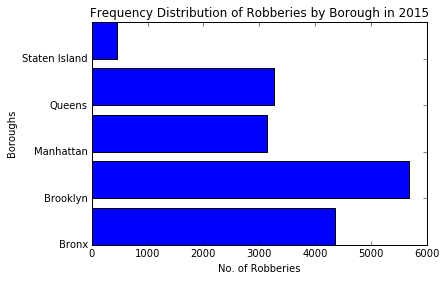

In [16]:
import numpy as np
%time nyc_crime_geo = IdaDataFrame(idadb,'NYC_CRIME_DATA',indexer = 'OBJECTID')
%time robberies_2015 = nyc_crime_geo[nyc_crime_geo['Offense']=='ROBBERY']
%time robberies_2015 = robberies_2015[robberies_2015['Occrr_Y'] == 2015]
%time robberies2015_brooklyn = len(robberies_2015[robberies_2015['Borough']=='BROOKLYN'])
%time robberies2015_bronx = len(robberies_2015[robberies_2015['Borough']=='BRONX'])
%time robberies2015_manhattan = len(robberies_2015[robberies_2015['Borough']=='MANHATTAN'])
%time robberies2015_queens = len(robberies_2015[robberies_2015['Borough']=='QUEENS'])
%time robberies2015_staten = len(robberies_2015[robberies_2015['Borough']=='STATEN ISLAND'])
%time robberies_count = [robberies2015_bronx,robberies2015_brooklyn,robberies2015_manhattan,robberies2015_queens,robberies2015_staten]
x = np.array([0,1,2,3,4])
y = np.array(robberies_count)
my_yticks = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
plt.yticks(x, my_yticks)
%time plt.barh(x, y)
plt.title('Frequency Distribution of Robberies by Borough in 2015')
plt.xlabel('No. of Robberies')
plt.ylabel('Boroughs')

We can further analyse the spatio-temporal pattern of crimes over a period of past decade for each Precinct. First we simply visualise the spatial distribution of the crimes as a scatterplot and cluster the crime locations based on spatial proximity. Further for the temporal analyses we need to first format the raw data into a timeseries which Python can understand and then visualise using the in-built matplotlib functions of pandas dataframe. Further, we can also analyse the autocorrelation and lag in the data if any.

C:\Users\IBM_ADMIN\AppData\Roaming\Python\Python27\site-packages\jaydebeapi\__init__.py:250: UserWarning:

No type mapping for JDBC type 'STRUCT' (constant value 2002). Using None as a default type_code.



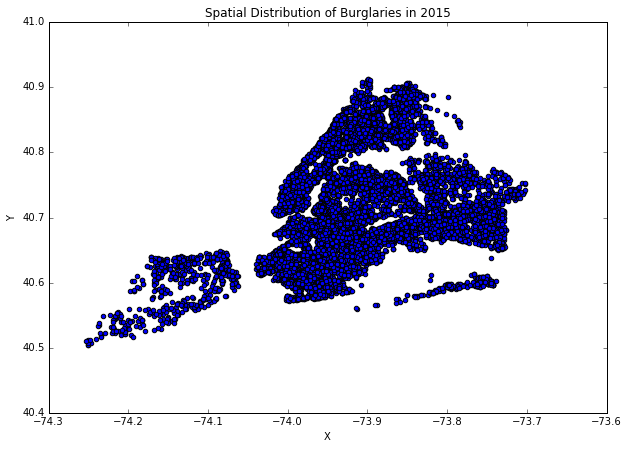

In [5]:
idadf = IdaGeoDataFrame(idadb,'NYC_CRIME_DATA',indexer = 'OBJECTID',geometry = 'GEO_DATA')
idadf = idadf[idadf['Occrr_Y'] == 2015]
idadf= idadf[idadf['Offense'] == "BURGLARY"]
idadf['X'] = idadf.x() # Using the spatial function ST_X and ST_Y to extract the coordinates
idadf['Y'] = idadf.y()
df = idadf[['Identfr','Occrrnc_Dt','Offense','Precnct','Borough','X','Y']].as_dataframe()
df.plot(kind='scatter', x='X', y='Y', title = 'Spatial Distribution of Burglaries in 2015', figsize=[10,7])

Since the crime data is geocoded, we can use the geospatial functions from the python library geopandas to analyse the geometry and then retrieve the results in the form of a choropleth map based upon the variation of crime density of each borough. In order to achieve this, we first use the ST_Area function of dashDB spatial to obtain the area of each borough in square meters. Following this, we find the number of crimes of type __"ROBBERY"__ in each borough in the year __2015__ using the ST_Within function and finally compute the density for each borough and try to visualise the results with __Leaflet__ library.

In [6]:
# Read the data from dahsDB using ibmdbpy
import ibmdbpy
from ibmdbpy import IdaDataBase,IdaDataFrame,IdaGeoDataFrame,IdaGeoSeries
#idadb = IdaDataBase('jdbc:db2://dashdb-entry-yp-dal09-07.services.dal.bluemix.net:50000/BLUDB:user=dash5548;password=Yc3HLDkUY2Ky')
boros = IdaGeoDataFrame(idadb,'NYC_BOROUGHS',indexer = 'OBJECTID')
felonies = IdaGeoDataFrame(idadb,'NYC_CRIME_DATA',indexer = 'OBJECTID')

#Set the geometry attribute and calculate area of the boroughs
boros.set_geometry('GEO_DATA')
felonies.set_geometry('GEO_DATA')
boros['area_in_sq_km'] = boros.area(unit = 'KILOMETER')
boros_df = boros[['BoroName','BoroCode','area_in_sq_km']].as_dataframe()


# Find the count of robberies in each borough fo 2015
felonies = felonies[felonies['Offense']=='ROBBERY']
robberies_2015 = felonies[felonies['Occrr_Y']==2015]
bronx = boros[boros['BoroName']=='Bronx']
brooklyn = boros[boros['BoroName']=='Brooklyn']
manhattan = boros[boros['BoroName']=='Manhattan']
queens = boros[boros['BoroName']=='Queens']
staten = boros[boros['BoroName']=='Staten Island']

result_bronx = robberies_2015.within(bronx)
result_brooklyn = robberies_2015.within(brooklyn)
result_manhattan = robberies_2015.within(manhattan)
result_queens = robberies_2015.within(queens)
result_staten = robberies_2015.within(staten)

bronx_count = result_bronx[result_bronx['RESULT']==1].shape[0]
manhattan_count = result_manhattan[result_manhattan['RESULT']==1].shape[0]
brooklyn_count = result_brooklyn[result_brooklyn['RESULT']==1].shape[0]
queens_count = result_queens[result_queens['RESULT']==1].shape[0]
staten_count = result_staten[result_staten['RESULT']==1].shape[0]
boros_df = boros[['OBJECTID','BoroCode','BoroName','area_in_sq_km']].as_dataframe()
boros_df['robberies_2015'] = [staten_count,queens_count,brooklyn_count,manhattan_count,bronx_count]

#Calculate the crime density
boros_df['crime_density'] = (boros_df['robberies_2015']/boros_df['area_in_sq_km'])*0.01
#Generate choropleth map with folium
import folium, json
with open('NYCboros.json', 'r') as f:
     boros_geo = json.load(f)
robberies = boros_df[['BoroCode','crime_density']]
map1 = folium.Map(location= (40.709475, -74.00275), 
                  zoom_start=10, tiles = 'cartodbpositron')
map1.choropleth(geo_str = boros_geo,
                data = robberies,
                columns = ['BoroCode', 'crime_density'],
                key_on = 'feature.properties.BoroCode',
                fill_color='YlGn',
                fill_opacity = 0.7,
                line_weight = 2,
                legend_name = 'Robbery densities by Borough')
map1

C:\Users\IBM_ADMIN\Anaconda2\lib\site-packages\ipykernel\__main__.py:54: FutureWarning:

'threshold_scale' default behavior has changed. Now you get a linear scale between the 'min' and the 'max' of your data. To get former behavior, use folium.utilities.split_six.



![png](images/plot2.png)